In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm

In [2]:
import torch
import torch.nn as nn
print("Using torch", torch.__version__)

Using torch 1.12.1+cu102


In [3]:
class DG_Agent:
    
    def __init__(self, seed, layer_sizes, alpha, gamma):
        torch.manual_seed(seed)
        self.alpha = alpha
        self.gamma = gamma
        self.action_space_len = layer_sizes[len(layer_sizes) - 1]
        net, layers = self.build_nn(layer_sizes)
        self.net = net
        self.layers = layers
            
        # self.net.cuda()
        self.loss_fn = nn.MSELoss()
        
        return
        
    def build_nn(self, layer_sizes):
        assert len(layer_sizes) > 1
        model_layers = []
        layers = []
        for index in range(len(layer_sizes)-1):
            linear = nn.Linear(layer_sizes[index], layer_sizes[index+1])
            #nn.init.normal_(linear.weight, 0, 1/np.sqrt(layer_sizes[index]))
            #nn.init.normal_(linear.bias, 0, 1/np.sqrt(layer_sizes[index]))
            nn.init.xavier_normal_(linear.weight)
            #nn.init.xavier_normal_(linear.bias)

            act = nn.Tanh() if index < len(layer_sizes)-2 else nn.Identity()#nn.Softmax(dim=1)
            model_layers += (linear,act)
            layers.append(linear)
        return nn.Sequential(*model_layers), layers
    
    def step(self, state, explore=True, epsilon = 0, log=False):
        self.net.zero_grad()
        output = self.net(torch.from_numpy(state).float())#.cuda()
        
        if epsilon == 0:
            if not explore:
                #action = torch.multinomial(output, 1)
                value, action = torch.max(output, axis=1)
                action = action.item() 
            else:
                value, action = torch.max(output, axis=1)
                action = action.item() 
        else:
            value, action = torch.max(output, axis=1)
            action = action.item() if torch.rand(1,).item() > epsilon else torch.randint(0,self.action_space_len,(1,)).item()
        
        if log:
            print("step ", state, output, action)
        
        return action

    # takes in an episode of experience's state action reward list
    def train(self, sar_list):
        losses = []
        decaying_future_reward = 0
        
        layer_changes = []
        for i, layer in enumerate(self.layers):  
            layer_changes.append((torch.zeros(layer.weight.shape), torch.zeros(layer.bias.shape)))
        
        for state, action, reward in reversed(sar_list):
            self.net.zero_grad()
            
            decaying_future_reward *= self.gamma
            decaying_future_reward += reward
            
            output = self.net(torch.from_numpy(state).float())#.cuda()
            
            target_return = output.clone().detach()
            target_return[0][action] = decaying_future_reward
        
            loss = self.loss_fn(output, target_return)
            loss.backward()
            losses.append(loss.item())
            
            for i, layer in enumerate(self.layers):                                
                layer_changes[i][0].add_(layer.weight.grad)
                layer_changes[i][1].add_(layer.bias.grad)
        
        with torch.no_grad():
            for i, layer in enumerate(self.layers):                                
                layer.weight -= (layer_changes[i][0]  * self.alpha) / len(sar_list)
                layer.bias -=  (layer_changes[i][1]  * self.alpha) / len(sar_list)
                
        return losses


accuracy:  0.979


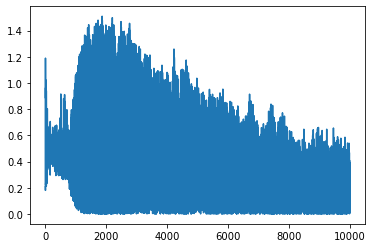

In [4]:
rewards = []
losses = []
agent = DG_Agent(seed=422, layer_sizes=[2, 64, 2], alpha=.001, gamma=0)
np.random.seed(422)
train_iters = 10000
eval_iters = 1000


# train on random crap
for i in range(train_iters):
    sars = []
    input = np.random.rand(1, 2)    
    action = agent.step(input, epsilon=i/train_iters)
        
    reward = 0
    value = np.max(input, axis=1)
    if value == input[0][action]:
        reward = 1
    else:
        reward = -1
    
    sars.append((input, action, reward))
    
    #print(output, action)
    # TODO: apply in place gets different end result than apply pending which is an issue
    # need to get apply pending to work to make training more stable
    train_losses = agent.train(sars)
    losses.extend(train_losses)

    #if i % 32 == 0:
        #agent.apply_pending_grads()

hits = 0
for i in range(eval_iters):
    input = np.random.rand(1, 2)    
    action = agent.step(input, explore=False)
    
    reward = 0
    value = np.max(input, axis=1)
    if value == input[0][action]:
        reward = 1
        hits += 1
    else:
        reward = -1
    
    #print(output, action)
    rewards.append(reward)
    #agent.train(output, action, reward)

print("accuracy: ", hits / eval_iters)
plt.cla()
plt.plot(losses)
plt.show()

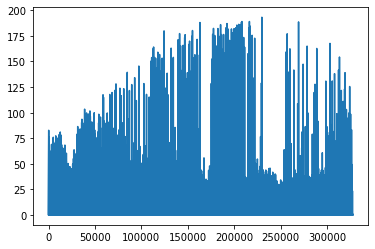

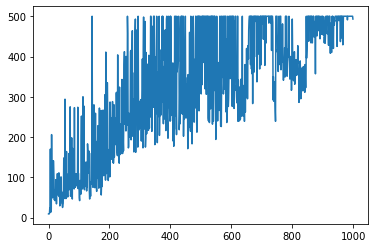

avg fitnesses 500.0


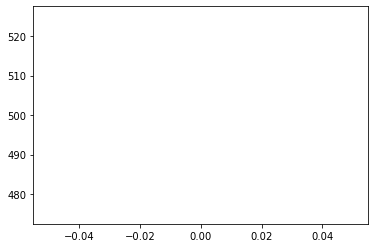

In [131]:
import gym
env = gym.make("CartPole-v1")
observation, info = env.reset()# seed=42

rewards = []
losses = []
agent = DG_Agent(seed=42, layer_sizes=[4, 64, 2], alpha=.01, gamma=.95)
np.random.seed(42)

train_iters = 10000
eval_iters = 1

# train
for i in range(train_iters):
    env_seed = np.random.randint(0, 1000)
    observation, info = env.reset(seed=env_seed)# seed=42
    sars = []
    total_reward = 0
    for k in range(1000):
        input_array = np.array(observation)
        input_array = input_array.reshape((1, 4))
        
        if (i % 10 == 0):
            action = agent.step(input_array, explore=False)
        else:
            action = agent.step(input_array, epsilon=(train_iters - float(i))/train_iters)
            
        observation, reward, terminated, truncated, info = env.step(action)
        
        training_reward = 0
        if np.abs(observation[2]) < .5:
            training_reward = 1
        
        if np.abs(observation[2]) > 1.5:
            training_reward = -1
            
        if np.abs(observation[1]) > 1:
            training_reward = -1
        
        if terminated:
            training_reward = -1
        
        total_reward += reward
        sars.append((input_array, action, reward))
        
        if terminated or truncated:
            terminated = False
            truncated = False
            break
    
    train_losses = agent.train(sars)
    
    if (i % 10 == 0):
        rewards.append(total_reward)
        losses.extend(train_losses)
                
plt.plot(losses)
plt.show()

plt.plot(rewards)
plt.show()

# eval 
fitnesses = []
tot = 0
for i in range(eval_iters):
    env_seed = np.random.randint(0, 1000)
    observation, info = env.reset(seed=env_seed)#seed=env_seed)# seed=42
    fitness = 0
    for k in range(1000): 
        input_array = np.array(observation)
        input_array = input_array.reshape((1, 4))
        action = agent.step(input_array, explore=False)#, log=True)#, explore=False)
        observation, reward, terminated, truncated, info = env.step(action)

        fitness += 1
        tot += 1
        
        if terminated or truncated:
            terminated = False
            truncated = False
            break
            
    fitnesses.append(fitness)

print("avg fitnesses", tot / eval_iters)
# print("accuracy: ", hits / eval_iters)
plt.cla()
plt.plot(fitnesses)
plt.show()

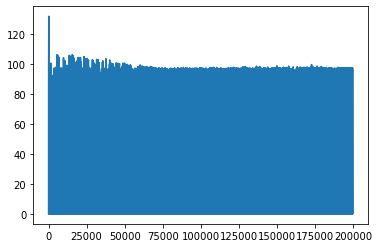

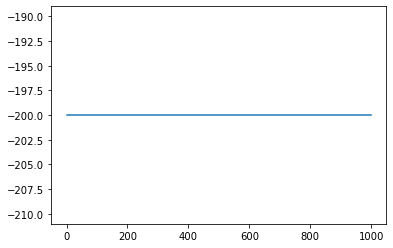

avg fitnesses 200.0


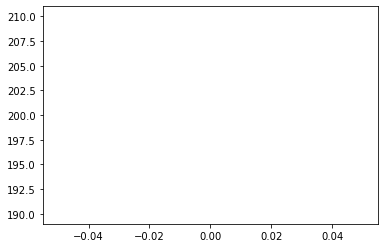

In [134]:
import gym
env = gym.make("MountainCar-v0")
observation, info = env.reset()# seed=42

rewards = []
losses = []
agent = DG_Agent(seed=42, layer_sizes=[2, 64, 3], alpha=.01, gamma=.95)
np.random.seed(42)

train_iters = 10000
eval_iters = 1

# train
for i in range(train_iters):
    env_seed = np.random.randint(0, 1000)
    observation, info = env.reset(seed=env_seed)# seed=42
    sars = []
    total_reward = 0
    for k in range(1000):
        input_array = np.array(observation)
        input_array = input_array.reshape((1, 2))
        
        if (i % 10 == 0):
            action = agent.step(input_array, explore=False)
        else:
            action = agent.step(input_array, epsilon=(train_iters - float(i))/train_iters)
            
        observation, reward, terminated, truncated, info = env.step(action)
        
        total_reward += reward
        sars.append((input_array, action, reward))
        
        if terminated or truncated:
            terminated = False
            truncated = False
            break
    
    train_losses = agent.train(sars)
    
    if (i % 10 == 0):
        rewards.append(total_reward)
        losses.extend(train_losses)
                
plt.plot(losses)
plt.show()

plt.plot(rewards)
plt.show()

# eval 
fitnesses = []
tot = 0
for i in range(eval_iters):
    env_seed = np.random.randint(0, 1000)
    observation, info = env.reset(seed=env_seed)#seed=env_seed)# seed=42
    fitness = 0
    for k in range(1000): 
        input_array = np.array(observation)
        input_array = input_array.reshape((1, 2))
        action = agent.step(input_array, explore=False)#, log=True)#, explore=False)
        observation, reward, terminated, truncated, info = env.step(action)

        fitness += 1
        tot += 1
        
        if terminated or truncated:
            terminated = False
            truncated = False
            break
            
    fitnesses.append(fitness)

print("avg fitnesses", tot / eval_iters)
# print("accuracy: ", hits / eval_iters)
plt.cla()
plt.plot(fitnesses)
plt.show()